# Check if is executing on Google Colab
If running on google colab download the repositories

In [16]:
try:
  import google.colab
  !git clone --recursive https://github.com/migperfer/AMPL-UPF-MSC
  IN_COLAB = True
except:
  IN_COLAB = False

fatal: destination path 'AMPL-UPF-MSC' already exists and is not an empty directory.


# Import libraries

In [0]:
from music21 import *
from music21.note import Note as noteclass
from music21.chord import Chord as chordclass
from music21.meter import TimeSignature as tsclass
import os, glob, math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Creation of Usul related objects
## Definition of the UsulStroke and Usul classes

In [0]:
class UsulStroke:
  def __init__(self, mnote, stroke, barduration):    
    self.stroketype = stroke.content
    self.duration = mnote.duration.quarterLength
    self.offset = mnote.beat
    self.barduration = barduration
    self.compatoffset = float(str(float((mnote.beat - 1)/barduration))[:4])
    if isinstance(mnote, chordclass):
      self.hand = "both"
    elif mnote.pitch.name == "F":
      self.hand = "right"
    elif mnote.pitch.name == "D":
      self.hand = "left"
    else:
      self.hand = "unknown"

  def __repr__(self):
    return "UsulStroke"

  def __str__(self):
    return "Stroke:%s, Duration:%s, Hand:%s, Offset:%s" % (self.stroketype, self.duration, self.hand, self.compatoffset)

class Usul:
  def __init__(self, usulname, strokes, nbeats):
    self.nbeats = nbeats
    self.usul = usulname
    self.strokes = strokes

  @classmethod
  def usul_from_file(cls, file):
    nbeats = 0
    score = converter.parse(file)
    rhythm = score.getElementsByClass('Part')[0].getElementsByClass('Measure')[0]
    notes = []
    for element in rhythm:
      if isinstance(element, (noteclass, chordclass)):
        notes.append(element)
      if isinstance(element, (tsclass)):
        nbeats = element.beatCount
        
    strokes = rhythm.getElementsByClass('TextExpression')
    usul_name = file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
    strokes_list = []
    for note in range(len(notes)):
      strk = UsulStroke(notes[note], strokes[note], nbeats)
      strokes_list.append(strk)
    return cls(usul_name, strokes_list, nbeats)


  def __iter__(self):
    self.index = 0
    return self

  def __getitem__(self, idx):
        return self.strokes[idx]

  def __next__(self):
    if self.index < len(self.strokes):
      idx = self.index
      self.index += 1
      return self.strokes[idx]
    else:
      raise StopIteration

  def _repr__(self):
    return "Usul"
  
  def __str__(self):
    return "Usul Object: %s" % (self.usul)

## Load all existing usuls with the classes created in last cell

We load all the usuls possible (the ones for which we have the scores), into the *usul_dict* dictionary

In [0]:
if IN_COLAB:
    usuls_files_list = glob.glob('./AMPL-UPF-MSC/scores/mxl/*.mxl')
else:
    usuls_files_list = glob.glob('./scores/mxl/*.mxl')

usuls_dict = {}
for usul_file in usuls_files_list:
  usul_name = usul_file.split('/')[-1].split('.mxl')[0].lower().replace('_', ' ')
  if '\\' in usul_name:  # Windows use \ instead of /
        usul_name = usul_name.split('\\')[-1]
  usuls_dict[usul_name] = Usul.usul_from_file(usul_file)

## Load define makams functions

In [0]:
usuldict = {'sofyan':0,'duyek':1,'raksaksagi':2,'cenber':3,'hafif':4,'devrikebir':5,'muhammes':6,'turkaksagi':7,'oynak':8,'havi':9,'aksak':10,'yuruksemai':11,'berefsan':12,'aksaksemai':13,'fahte':14,'semai':15,'cifteduyek':16,'evfer':17}
makamlist = ['hicaz','rast','nihavent','ussak','segah','huseyni','huzzam','mahur','kurdilihicazkar','muhayyer']
makamdict = {makamlist[i]:i for i in range(len(makamlist))}

rast = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'D5','Lead':'F4#'}
huseyni = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'E5','Lead':'G4'}
muhayyer = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'A5','sDom':'E5','Lead':'G4'}
ussak = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'D5','Lead':'G4'}
hicaz = {'A': 1, 'B':2,'C':3,'D':4,'E':5,'F':6, 'G':7,'Dom':'D5','Lead':'G4'}
huzzam = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':'D5','Lead':'A4#'}
kurdilihicazkar = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'G5','Lead':'F4'} 
nihavent = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'D5','Lead':'F4#'}
segah = {'B':1,'C':2,'D':3,'E':4,'F':5, 'G':6,'A':7,'Dom':'D5','Lead':'A4#'}
mahur = {'G': 1, 'A': 2, 'B':3,'C':4,'D':5,'E':6,'F':7,'Dom':'G5','Lead':'F4#'}

if IN_COLAB:
    folder = 'AMPL-UPF-MSC/SymbTr/txt/'
else:
    folder = 'SymbTr/txt/'

allScores = os.listdir(folder)

def getDegree(note,makam):
    significance = None
    degree = eval(makam)[note[0]]
    if degree == 1:
        significance = 'Tonic'
    if note[:2] == eval(makam)['Dom']:
        significance = 'Dominant'
    if note[:2] == eval(makam)['Lead']:
        significance = 'Leading'    
    return degree,significance

def getbars(makam,usul):
    bars = []
    bar = []
    for file in allScores:
        mak,_,us = file.split('--')[:3]
        
        if (mak != makam) or (us != usul):
            continue
        
        with open(folder + file, encoding="utf8") as scoretxt:
            txtlines = scoretxt.read().split('\n')
        for i in range(2,len(txtlines)-1):
            if int(txtlines[i].split('\t')[1])==51: # possible usul change, leave the rest
                break
            if int(txtlines[i].split('\t')[6])>0:
                dur = int(txtlines[i].split('\t')[6])/int(txtlines[i].split('\t')[7])
                notename = txtlines[i].split('\t')[3]
                degree, significance = getDegree(notename,mak)
                offset = txtlines[i].split('\t')[-1]     
                bar.append([offset,dur,notename,degree,significance])
                if float(offset).is_integer():
                    bars.append(bar)
                    bar = []
    return bars

## Function to analyze a makam using an usul object

In [0]:
def analyze_makam(makam_name, usul_name):
    usul_part = usul_name.replace("ü", "u").replace(" ", "").replace("ç","c").replace("ğ","g").replace("ş","s").replace("-","")
    makam_part = makamdict[makam_name]
    makam = getbars(makam_name, usul_part)
    if makam == []:
      raise ValueError("Can't load makam %s-%s" % (makam_name, usul_part))
    usul = usuls_dict[usul_name]
    coincidences = []
    usul_onsets = []
    for stroke in usul:
        usul_onsets.append(stroke.compatoffset)  # Get the position of every stroke in this
    onsets_indx = dict((k,i) for i,k in enumerate(usul_onsets))  # Store the index of every beat position

    notes_total = 0
    notes_coinc = 0  # to see how many notes coincide 

    for bar in makam:
        for note in bar:
            beat, bar = math.modf(float(note[0]))  # Split the integer part and the decimal one
            beat = beat # Substract the duration, to get the beat position
            beat = float(str(beat)[:4])  # Limit to 4 the number of decimals

            notes_total += 1
            if beat in usul_onsets:
                notes_coinc += 1
                coinc_stroke = usul[onsets_indx[beat]]  # Get coincident stroke
                coincidence = {'hand': coinc_stroke.hand, 'duration': coinc_stroke.duration, 'stroke': coinc_stroke.stroketype, 'offset':coinc_stroke.compatoffset,
                               'note_name': note[2], 'note_degree': note[3], 'note_significance': note[4], 'makam': makam_name, 'usul': usul_name}
                coincidences.append(coincidence)
    coincidences = pd.DataFrame(coincidences)
    print(makam_name, usul_name, ": %f percent of notes coincide with usul beats" %(notes_coinc/notes_total))
    return coincidences
            

## Analyze the scores
Analyze the scores and save them into a folder called _csv-data_

In [22]:
if not os.path.isdir('csv-data/'):
  os.mkdir('csv-data/')
import gc
empty_ones = []
broken_ones = []
for usul_key in usuls_dict.keys():
  for makam_key in makamdict.keys():
    print("Analizing %s-%s" % (usul_key, makam_key))
    try:
      results = analyze_makam(makam_key, usul_key)
    except ValueError:
      print("\tBroken %s, %s" % (makam_key, usul_key))
      broken_ones.append("%s, %s" % (makam_key, usul_key))
      continue
    if not results.empty:
      results.to_csv('csv-data/%s-%s.csv' % (usul_key, makam_key))
      print("\tAnalyzed %s-%s" % (usul_key, makam_key))
    else:
      print("\tEmpty: ", usul_key, makam_key)
      empty_ones.append("%s-%s" % (usul_key, makam_key))
  gc.collect()
with open('csv-data/empty_ones.txt', 'w', encoding="utf8") as file:
  for empty in empty_ones:
    file.write("%s\n" % empty)
with open('csv-data/broken_ones.txt', 'w', encoding="utf8") as file:
  for broken in broken_ones:
    file.write("%s\n" % broken)

Analizing türk aksaği-hicaz
hicaz türk aksaği : 0.282284 percent of notes coincide with usul beats
	Analyzed türk aksaği-hicaz
Analizing türk aksaği-rast
rast türk aksaği : 0.351016 percent of notes coincide with usul beats
	Analyzed türk aksaği-rast
Analizing türk aksaği-nihavent
nihavent türk aksaği : 0.316089 percent of notes coincide with usul beats
	Analyzed türk aksaği-nihavent
Analizing türk aksaği-ussak
ussak türk aksaği : 0.290323 percent of notes coincide with usul beats
	Analyzed türk aksaği-ussak
Analizing türk aksaği-segah
segah türk aksaği : 0.312644 percent of notes coincide with usul beats
	Analyzed türk aksaği-segah
Analizing türk aksaği-huseyni
huseyni türk aksaği : 0.328859 percent of notes coincide with usul beats
	Analyzed türk aksaği-huseyni
Analizing türk aksaği-huzzam
huzzam türk aksaği : 0.240789 percent of notes coincide with usul beats
	Analyzed türk aksaği-huzzam
Analizing türk aksaği-mahur
	Broken mahur, türk aksaği
Analizing türk aksaği-kurdilihicazkar
kur

# Analyse the data

In [23]:
all_files = glob.glob("csv-data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, header=0, index_col=0)
    li.append(df)

frame = pd.concat(li, axis=0)
frame.head()

,hand,duration,stroke,offset,note_name,note_degree,note_significance,makam,usul
0,right,0.5,Te,0.22,A4,2,NaN,nihavent,aksak
1,left,0.5,Ke,0.33,B4b5,3,NaN,nihavent,aksak
2,right,1.0,Düm,0.44,C5,4,NaN,nihavent,aksak
3,left,1.0,Tek,0.66,E5b5,6,NaN,nihavent,aksak
4,left,0.5,Tek,0.88,G5,1,Tonic,nihavent,aksak


## Overall note significance


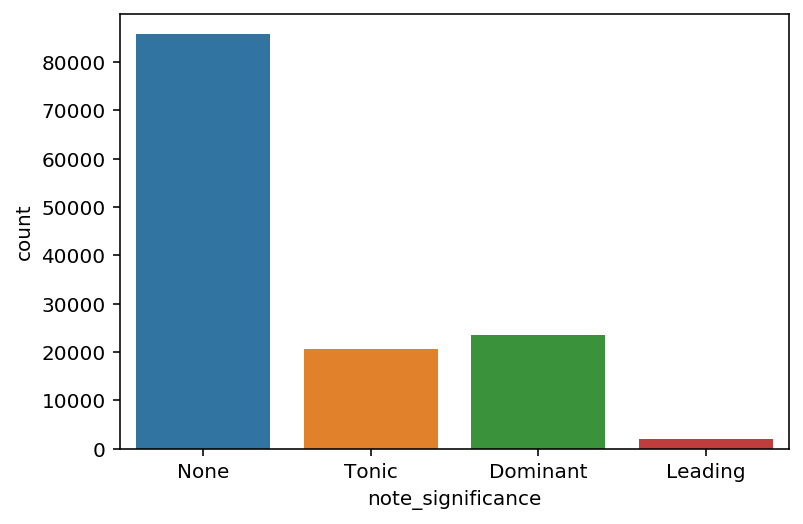

In [24]:
sns.countplot(frame['note_significance'].fillna("None"))
plt.show()

## Offset of the notes


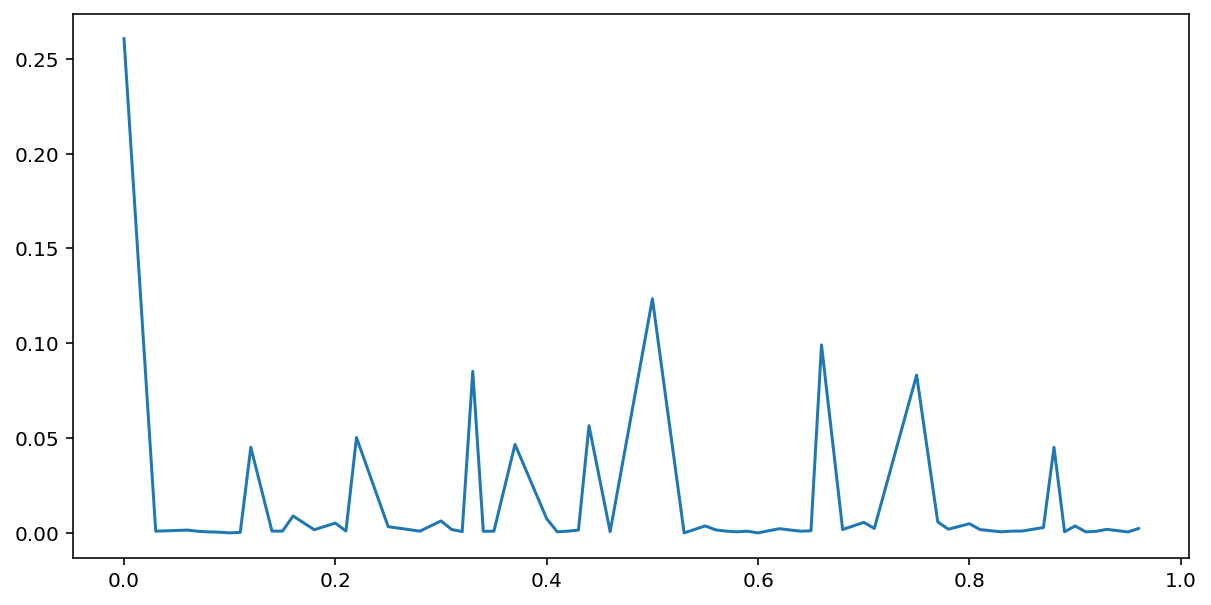

In [49]:
fig = plt.figure(figsize = (10,5))
ax = fig.gca()
sns.lineplot(data=frame.offset.value_counts().sort_index()/len(frame), ax=ax)
plt.show()

## Note significance according to hand


In [82]:
both_hands = frame[frame['hand'] == 'both']
both_hands.groupby(by=['hand', 'note_significance']).count()/len(both_hands)*100

duration   stroke  ...    makam     usul
hand note_significance                     ...                  
both Dominant            10.6250  10.6250  ...  10.6250  10.6250
     Leading              0.3125   0.3125  ...   0.3125   0.3125
     Tonic               16.2500  16.2500  ...  16.2500  16.2500

[3 rows x 7 columns]

In [83]:
right_hands = frame[frame['hand'] == 'right']
right_hands.groupby(by=['hand', 'note_significance']).count()/len(right_hands)*100

duration     stroke  ...      makam       usul
hand  note_significance                        ...                      
right Dominant           18.038222  18.038222  ...  18.038222  18.038222
      Leading             1.731817   1.731817  ...   1.731817   1.731817
      Tonic              16.754657  16.754657  ...  16.754657  16.754657

[3 rows x 7 columns]

In [86]:
left_hands = frame[frame['hand'] == 'left']
left_hands.groupby(by=['hand', 'note_significance']).count()/len(left_hands)*100

duration     stroke  ...      makam       usul
hand note_significance                        ...                      
left Dominant           17.533905  17.533905  ...  17.533905  17.533905
     Leading             1.136457   1.136457  ...   1.136457   1.136457
     Tonic              14.349202  14.349202  ...  14.349202  14.349202

[3 rows x 7 columns]

## Note significance according to stroke type

In [96]:
d1 = frame.groupby(['note_significance', 'stroke']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance stroke           
Dominant          Dum      9.243072
                  Düm     38.106751
                  Hek      0.316161
                  Ka       0.581179
                  Ke       7.160126
                  Ta       0.613725
                  Te       9.796355
                  Tek     34.182630
Leading           Dum      6.488128
                  Düm     50.082827
                  Hek      0.110436
                  Ka       0.828272
                  Ke       7.702927
                  Ta       0.773054
                  Te      10.795141
                  Tek     23.219216
Tonic             Dum      9.228449
                  Düm     43.302921
                  Hek      0.531575
                  Ka       0.715582
                  Ke       7.666948
                  Ta       0.449794
                  Te       8.479644
                  Tek     29.625086

## Note significance according to note duration

In [106]:
d1 = frame.groupby(['note_significance', 'duration']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance duration           
Dominant          0.5       17.760833
                  1.0       64.352799
                  1.5        0.599777
                  2.0       16.840245
                  4.0        0.446346
Leading           0.5       15.074544
                  1.0       65.599117
                  1.5        0.662617
                  2.0       18.663722
Tonic             0.5       16.131258
                  1.0       62.112500
                  1.5        0.329679
                  2.0       20.874543
                  4.0        0.552020

## Stroke distribution according to hand

In [114]:
d1 = frame.groupby(['hand', 'stroke']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
hand  stroke            
both  Hek     100.000000
left  Ka        1.580436
      Ke       17.600575
      Tek      80.818988
right Dum      15.474418
      Düm      67.627480
      Ta        0.979185
      Te       15.918917

## Note significance according to makam

In [102]:
d1 = frame.groupby(['note_significance', 'makam']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance makam                     
Dominant          hicaz            14.506230
                  huseyni           8.968756
                  huzzam           10.589083
                  kurdilihicazkar   5.379394
                  mahur             8.101637
                  muhayyer          4.063604
                  nihavent         15.345453
                  rast             11.200484
                  segah            10.431002
                  ussak            11.414357
Leading           hicaz            27.139702
                  huseyni          24.599669
                  kurdilihicazkar   4.030922
                  muhayyer          7.647708
                  ussak            36.581999
Tonic             hicaz            18.842802
                  huseyni          10.335046
                  huzzam            7.932735
                  kurdilihicazkar   2.287306
                  mahur             3.779805
                  muhayyer          4.584835
                  nihavent         16.177260
                  rast             12.047331
                  segah            10.695392
                  ussak            13.317488

## Note significance according to Usul type

In [99]:
d1 = frame.groupby(['note_significance', 'usul']).agg({'duration': 'sum'})
d1.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))

duration
note_significance usul                   
Dominant          aksak         24.725683
                  aksak semai    3.654454
                  berefşan       1.339037
                  devr-i kebir   2.273573
                  düyek         19.369537
                  evfer          1.469221
                  fahte          0.390552
                  hafif          3.384787
                  havi           0.065092
                  muhammes       1.487818
                  oynak          0.153431
                  raks aksaği    1.157709
                  semai         12.748745
                  sofyan        18.421053
                  türk aksaği    3.147666
                  yürük semai    4.124047
                  çenber         1.710991
                  çifte düyek    0.376604
Leading           aksak         28.989509
                  aksak semai    7.675318
                  devr-i kebir   1.656543
                  düyek         13.500828
                  evfer          3.672004
                  fahte          0.552181
                  hafif          0.496963
                  havi           0.220872
                  muhammes       0.938708
                  raks aksaği    3.865268
                  semai          3.865268
                  sofyan        25.952512
                  türk aksaği    2.843733
                  yürük semai    4.389840
                  çenber         0.828272
                  çifte düyek    0.552181
Tonic             aksak         22.883283
                  aksak semai    3.243119
                  berefşan       0.766695
                  devr-i kebir   3.005444
                  düyek         17.886989
                  evfer          1.571724
                  fahte          0.449794
                  hafif          2.816325
                  havi           0.255565
                  muhammes       0.920034
                  oynak          0.240231
                  raks aksaği    1.929515
                  semai         11.117074
                  sofyan        23.537530
                  türk aksaği    3.621355
                  yürük semai    3.317233
                  çenber         1.533390
                  çifte düyek    0.904700

## Note significance distribution according to Usul and Makam

In [0]:
for usul_key in usuls_dict.keys():
  usul = usuls_dict[usul_key]
  usul_onsets = []
  stroke_names = []
  for stroke in usul:
    usul_onsets.append(stroke.compatoffset)
    stroke_names.append(stroke.stroketype)
  usul_onsets = np.asarray(usul_onsets)

  for makam_key in makamdict.keys():
    try:
      coincidences = analyze_makam(makam_key, usul_key)
    except ValueError:
      continue
    if not coincidences.empty:

      Dominant = np.zeros(usul_onsets.shape[0])
      Leading = np.zeros(usul_onsets.shape[0])
      Tonic = np.zeros(usul_onsets.shape[0])
      nan = np.zeros(usul_onsets.shape[0])

      grouped = coincidences.groupby(['note_significance','offset'])
      for g in grouped.groups:
        eval(str(g[0]))[np.where(usul_onsets==g[1])[0][0]] = len(grouped.groups[g])

      for i in range(usul_onsets.shape[0]):  # convert to percentages
        Dominant[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        Leading[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        Tonic[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]
        nan[i] /=  Dominant[i] + Leading[i] + Tonic[i] + nan[i]

      
      width = 0.05/(0.4*usul_onsets.shape[0])
      fig , ax = plt.subplots(figsize=(1.15*usul_onsets.shape[0],5))

      rects1 = ax.bar(usul_onsets + width, Tonic, width, label='Tonic')
      rects2 = ax.bar(usul_onsets, Dominant, width, label='Dominant')
      rects3 = ax.bar(usul_onsets - width, Leading, width, label='Lead')

      ax.set_xticks(usul_onsets)
      ax.set_xticklabels(stroke_names)
      ax.set_title("Makam: %s  Usul: %s" % (makam_key,usul_key))
      ax.legend()
